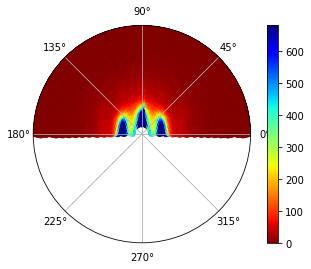

Figure 1: 2D data


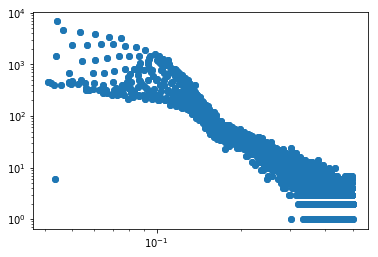

Figure 2: 1D data


In [22]:
# In this notebook the 2D pair distance distribution function is extracted from 
# the 2D small-angle scattering data (here SAXS, but could be also SANS) of aligned magnetotactic bacteria
# by a singular value decomposition (SVD).
# In the first part (A) we use the truncated SVD, and in the second part (B) a conventional SVD.
# The results using the truncated SVD are published in: 
# "Using the singular value decomposition to extract 2D correlation functions from scattering patterns"
# https://doi.org/10.1107/S205327331900891X

#==============================================================================
# import of used packages
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from numpy.linalg import svd
#==============================================================================
# import of data
theta,q,Iq= np.genfromtxt('../data/MTB-2DSAXS_data.txt',unpack=True,skip_header=0,skip_footer=0,usecols=(0,1,2))

Nq=len(q) # total number of combined q and theta value 

qmax=round(max(q),2)
#==============================================================================
# Plot data

sI=np.sqrt(q)*100.

figS = plt.figure()
axS = figS.add_subplot(111, projection='polar')
cS = axS.scatter(theta, q, c=Iq, s=sI, marker='o', vmin=0, vmax=0.1*max(Iq), cmap='jet_r',alpha=1)
axS.set_rmax(qmax)
axS.set_rticks([])
plt.colorbar(cS,orientation='vertical')
plt.show()
print('Figure 1: 2D data')     

plt.plot(q,Iq,'o')
plt.xscale('log')
plt.yscale('log')
plt.show()
print('Figure 2: 1D data')

#==============================================================================
# phi and r are the polar coordinates in real space

Nr=51 # number of r values in P(r) distributions
Nphi=72 # number of phi values for which P(r) is determined 
N=Nr*Nphi # total number of combined r and phi values 

Dmax=200 # maximal size of scatteres as usually defined for IFTs

r1=np.linspace(0,Dmax,Nr)
r1[0]=+1.e-3 # r can't start at 0

Deltaphi=360.0/float(Nphi)
phi11=np.linspace(0.,360.0-Deltaphi,Nphi)
phi1=phi11/180.0*np.pi
       
r=[]
phi=[]  
phiGrad=[]            
for i in range(Nphi):
    for j in range(Nr):
        r.append(r1[j])
        phi.append(phi1[i])

#==============================================================================
# Construction of system matrix K

def Aij(q,theta,r,phi):
    return np.cos(q*r*np.cos(theta-phi))

qmat=np.tile(q,(N,1)).T
thetamat=np.tile(theta,(N,1)).T
rmat=np.tile(r,(Nq,1))
phimat=np.tile(phi,(Nq,1))
 
K=Aij(qmat,thetamat,rmat,phimat)  

Part A: Truncated singular value decomposition (TSVD)


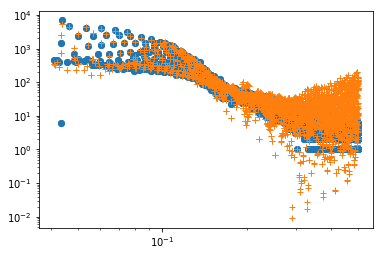

Figure A.1: 1D plot of data and fit (TSVD)


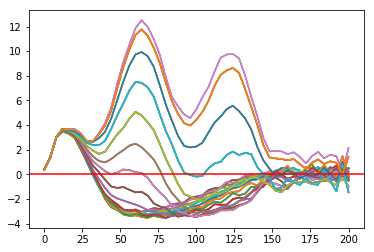

Figure A.2: 1D plot of all distributions (TSVD)


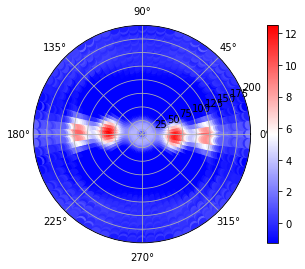

Figure A.3: 2D plot of P(r) (TSVD)


In [23]:
#==============================================================================
#==============================================================================
# A) truncated SVD (TSVD))
print('Part A: Truncated singular value decomposition (TSVD)')
#==============================================================================
#==============================================================================
# A.1) the decomposition itself

# these are all the parameters for the truncated SVD. Most important one is Nrank!
Nrank=900 # Initial number of singular values, which are considered (Nr of components for randomized_svd).
Noversamples='auto' # 10 is the default value (see randomized_svd)
Niter='auto' # number of iterations (see randomized_svd); usually 4-5 are sufficient (auto starts with 4)
PowerIteration='QR' # possible modes are 'auto', 'QR', 'LU', 'none' (QR is most accurate but slowest)
Transpose='auto' # possible modes are 'auto', 'True', 'False'
FlipSign='True'
State=None # should be 0 or None

U, s, V = randomized_svd(K, 
                         n_components=Nrank, 
                         n_iter=Niter, 
                         power_iteration_normalizer=PowerIteration, 
                         transpose=Transpose,
                         flip_sign=FlipSign,
                         random_state=State)

#==============================================================================
# A.2) reconstruction of correlation function P(r)

b=(U.T).dot(Iq)
g=b/s
Pr=(V.T).dot(g)
Iqfit=K.dot(Pr)
PrList=np.reshape(Pr,(Nphi,Nr))

#==============================================================================
# A.3) Plots

py.loglog(q,Iq,'o')
py.loglog(q,Iqfit,'+')
py.show()
print('Figure A.1: 1D plot of data and fit (TSVD)')

for i in range(Nphi):    
    py.plot(r1,PrList[i,:])
plt.axhline(y=0.0, color='r', linestyle='-')    
py.show()  
print('Figure A.2: 1D plot of all distributions (TSVD)')

PrMax=abs(np.max(Pr))
r=np.asarray(r)
sP=r*0.5

figC = plt.figure()
axC = figC.add_subplot(111, projection='polar')
cC = axC.scatter(phi, r, c=Pr, s=sP,  marker='o', vmin=-PrMax/10.0,vmax=PrMax, cmap='bwr')
axC.set_rmax(Dmax)
plt.colorbar(cC,orientation='vertical')
py.show()
print('Figure A.3: 2D plot of P(r) (TSVD)') 

In [24]:
#==============================================================================
#==============================================================================
# B) standard SVD (SVD))
print('Part B: Standard singular value decomposition (SVD)')
#==============================================================================
#==============================================================================
# B.1) the decomposition itself

U2,s2,V2 = svd(K, full_matrices=False)

Part B: Standard singular value decomposition (SVD)


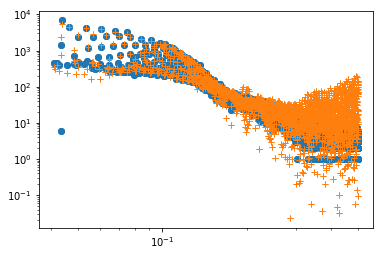

Figure B.1: 1D plot of data and fit (SVD)


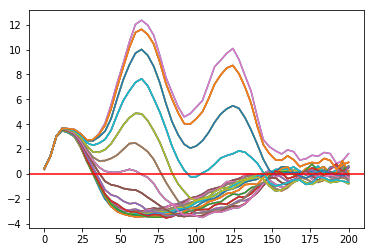

Figure B.2: 1D plot of all distributions (SVD)


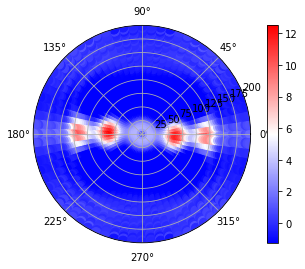

Figure B.3: 2D plot of P(r) (SVD)


In [28]:
#==============================================================================
# B.2) reconstruction of correlation function P(r)

rank=20 # number of singular values considered for reconstruction

b2=(U2.T).dot(Iq)

g1=[]
for i in range(len(b2)):
    if s2[i]>rank:
        g1.append(b2[i]/s2[i])
    else:
        g1.append(0)

g2=np.asarray(g1)

Vm2=(V2.T).dot(g2)

Pr2=np.asarray(Vm2)    
PrList2=np.reshape(Pr2,(Nphi,Nr))
Iqfit2=K.dot(Pr2)

#==============================================================================
# B.3) Plots

py.loglog(q,Iq,'o')
py.loglog(q,Iqfit2,'+')
py.show()
print('Figure B.1: 1D plot of data and fit (SVD)')

for i in range(Nphi):    
    py.plot(r1,PrList2[i,:])
plt.axhline(y=0.0, color='r', linestyle='-')    
py.show()  
print('Figure B.2: 1D plot of all distributions (SVD)')

PrMax2=abs(np.max(Pr2))
r=np.asarray(r)
sP=r*0.5

figC = plt.figure()
axC = figC.add_subplot(111, projection='polar')
cC = axC.scatter(phi, r, c=Pr2, s=sP,  marker='o', vmin=-PrMax/10.0,vmax=PrMax, cmap='bwr')
axC.set_rmax(Dmax)
plt.colorbar(cC,orientation='vertical')
py.show()
print('Figure B.3: 2D plot of P(r) (SVD)') 